#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [1]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

Read the spectral data

You will need to run [PageRank_Filter_Before_Clean.ipynb](../Outlier_Detection/PageRank_Filter_Before_Clean.ipynb) if you haven't already to create this file.

In [2]:
df = pd.read_csv("../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


#### **Select the chosen cleaning parameters then run the functions**

#### **Here is an example on 1 Spectra**

In [4]:
# Optuna Outlier Parameters
pagerank_cutoff = 0.974295111197113
despike_ma = 57
despike_threshold = 3.75
lam = 10 ** 10
p = 0.081
# window_size = 51
# poly_order = 3

#### **Here is an example on 1 Spectra**

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

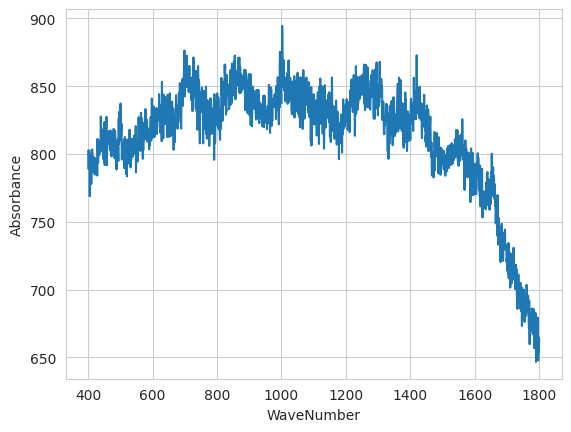

In [5]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Despike

In [6]:
# sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
# sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Baseline Correction

/tmp/ipykernel_49306/2601916869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


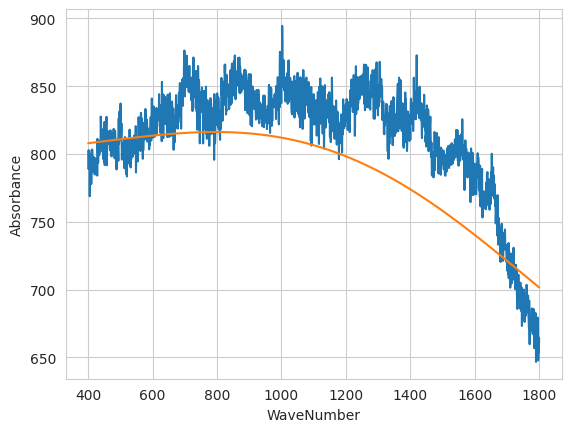

/tmp/ipykernel_49306/2601916869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

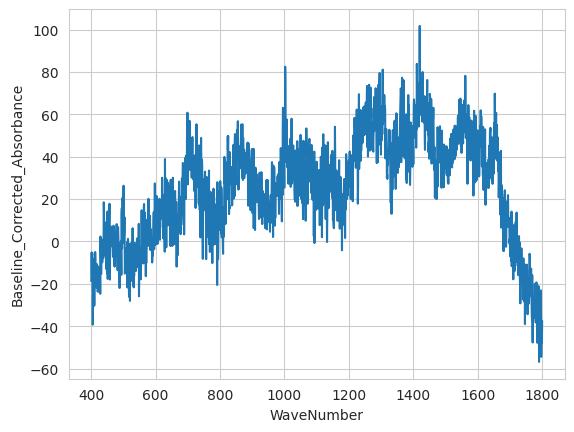

In [7]:
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)
plt.show()

# Subtract the baseline
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Scale the spectra

/tmp/ipykernel_49306/214950190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: snv_normalise(x))


<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

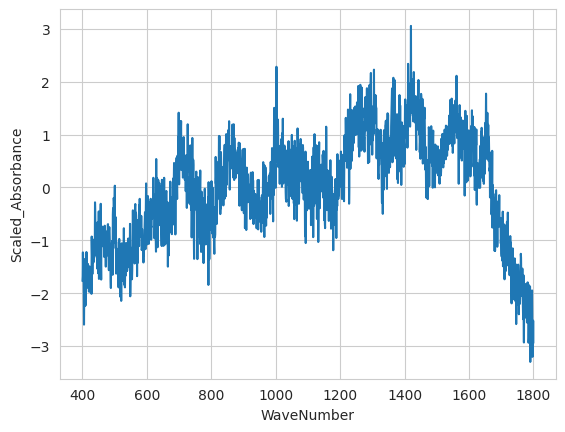

In [8]:
sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: snv_normalise(x))
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)

In [9]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [10]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

In [11]:
df['Absorbance'] = df['Absorbance'] - df['Baseline']

In [12]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [13]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: snv_normalise(x))

In [14]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Baseline
0,201210-1-00,293,400.22778,-0.607078,201210-1,Normal,0.610024,1752.738954
1,201210-1-00,294,400.91116,-0.379813,201210-1,Normal,0.610024,1752.557331
2,201210-1-00,295,401.59454,-0.515909,201210-1,Normal,0.610024,1752.375708
3,201210-1-00,296,402.27789,-0.819588,201210-1,Normal,0.610024,1752.194085
4,201210-1-00,297,402.96127,-0.755350,201210-1,Normal,0.610024,1752.012462
...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-2.261378,210526-3,Hyperglycemia,1.201164,1712.119503
6239201,210526-3-09,2338,1797.72200,-2.052961,210526-3,Hyperglycemia,1.201164,1711.590350
6239202,210526-3-09,2339,1798.40550,-2.043384,210526-3,Hyperglycemia,1.201164,1711.061196
6239203,210526-3-09,2340,1799.08890,-1.926663,210526-3,Hyperglycemia,1.201164,1710.532043


In [15]:
df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

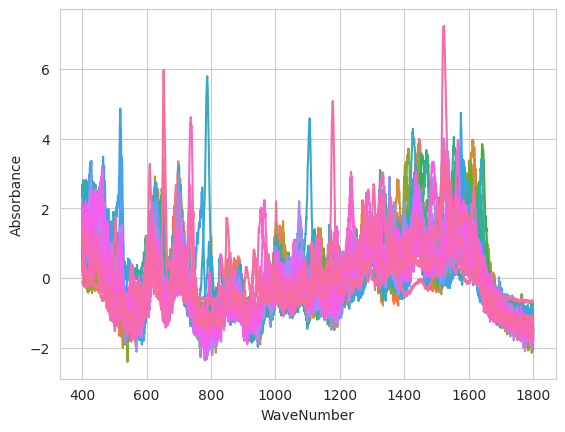

In [16]:
surface = df[df['SurID'] == '210303-1']
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=False)

In [17]:
remaining_df = surface[surface['PageRank'] > pagerank_cutoff]
droped_df = surface[surface['PageRank'] <= pagerank_cutoff]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

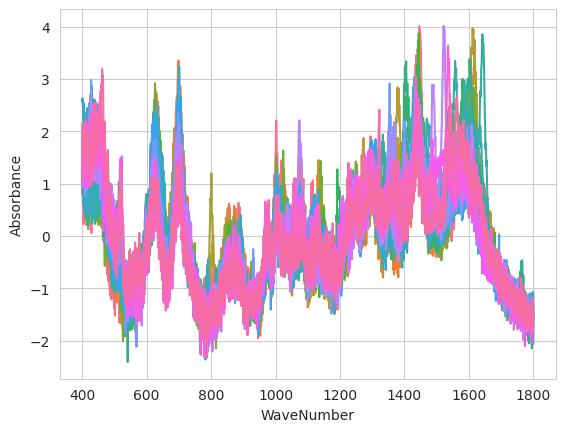

In [18]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=remaining_df, hue='SpecID', legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

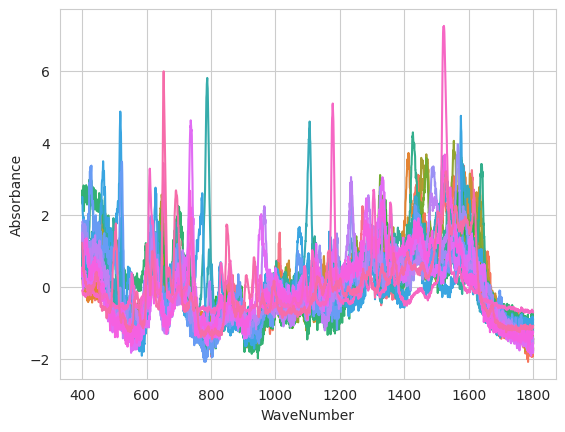

In [19]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=droped_df, hue='SpecID', legend=False)

Filter the dataset by pagerank.

In [20]:
df = df[df['PageRank'] > pagerank_cutoff]

In [21]:
len(df.groupby('Status'))

3

In [22]:
df.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    438
Hypoglycemia     571
Normal           555
Name: SpecID, dtype: int64

In [23]:
df.groupby('Status')['SurID'].nunique()

Status
Hyperglycemia    19
Hypoglycemia     22
Normal           22
Name: SurID, dtype: int64

In [24]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    # Cross Validate
    scores = cross_validate(model, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [25]:
rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=60)
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

evaluate_model(wavelength_df, rf)

RandomForestClassifier Cross-Validation Accuracy: 0.6643 +/- 0.0509
RandomForestClassifier Cross-Validation Precision: 0.6673 +/- 0.0525
RandomForestClassifier Cross-Validation Recall: 0.6727 +/- 0.0610
RandomForestClassifier Cross-Validation F1-Score: 0.6401 +/- 0.0404


/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Evalutate By Class**

In [26]:
def evaluate_model_by_class(df, model):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names from the 'y' dataset
    class_names = y.unique()
    
    cv = GroupKFold(n_splits=10)

    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [27]:
evaluate_model_by_class(wavelength_df, rf)

RandomForestClassifier Cross-Validation Accuracy: 0.6966 +/- 0.1481

Normal Precision: 0.6489 +/- 0.3186
Normal Recall: 0.5487 +/- 0.3615
Normal F1-Score: 0.5421 +/- 0.3374

Hyperglycemia Precision: 0.5810 +/- 0.2302
Hyperglycemia Recall: 0.6365 +/- 0.2625
Hyperglycemia F1-Score: 0.5974 +/- 0.2295

Hypoglycemia Precision: 0.7752 +/- 0.2208
Hypoglycemia Recall: 0.7872 +/- 0.1648
Hypoglycemia F1-Score: 0.7445 +/- 0.1543



**Use Spectra Predictions to Predict the Surface**

In [28]:
def evaluate_and_predict_surface_status(df, model):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        model.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = model.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })
        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()

In [29]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df, rf)
surface_predictions

,SurID,ActualStatus,PredictedStatus
0,201210-1,Normal,Normal
1,201210-2,Normal,Hypoglycemia
2,210114-1,Normal,Normal
3,210114-2,Normal,Normal
4,210120-1,Hyperglycemia,Normal
...,...,...,...
58,210519-3,Hyperglycemia,Hyperglycemia
59,210524-1,Hypoglycemia,Hyperglycemia
60,210526-1,Hyperglycemia,Hyperglycemia
61,210526-2,Hyperglycemia,Normal


In [30]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus']))

               precision    recall  f1-score   support

Hyperglycemia       0.70      0.74      0.72        19
 Hypoglycemia       0.72      0.82      0.77        22
       Normal       0.78      0.64      0.70        22

     accuracy                           0.73        63
    macro avg       0.73      0.73      0.73        63
 weighted avg       0.73      0.73      0.73        63

